## Tutorial for Human Activity Recognition

In [1]:
import yaml
import torch
import torch.nn as nn
from tqdm import tqdm
import os

## Dataset with radHAR: 
radHAR dataset is designed to use mmWave PC data collected by IWR1443Ti to predict the actions of the users.
There are totally 5 actions in the dataset: ['boxing','jack','jump','squats','walk']

In the library, we provide a dataloader to use mmWave PC data , converted into voxel image, and predict these actions. 

### Load the data

In [2]:
from dataset.har import load_har_dataset
# The path contains the radHAR dataset
root =  '/home/junqiao/projects/mmWave_sensing/RadHAR/Data/' 
train_dataset, test_dataset = load_har_dataset("radHAR", root)

using dataset: radHAR DATA


### Visualize the voxel image

(60, 10, 32, 32) <class 'numpy.ndarray'>


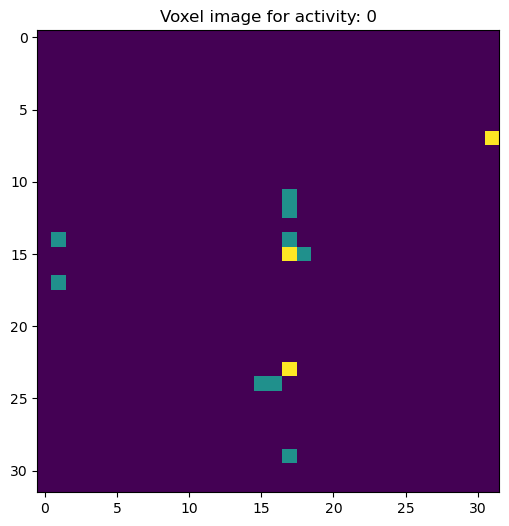

In [3]:
from matplotlib import pyplot as plt
# Example of the samples in the dataset
index = 9  # Randomly select an index
voxels,activity = train_dataset.__getitem__(index)


print(voxels.shape, type(voxels))

plt.figure(figsize=(10,6))
plt.imshow(voxels[0].transpose(1,2,0).mean(-1))
plt.title("Voxel image for activity: {}".format(activity))
plt.show()

## Create model 
raHAR utilizes MLP-based model as a baseline har method. From model.har, we can import desired har model designed for mmWave PC. The model parameter for har_MLP reimplemented for radHAR is as follows:

In [4]:
from model.har import har_MLP
model = har_MLP(dataset="radHAR", num_classes=5)
print(model)

har_MLP(
  (fc): Sequential(
    (0): Linear(in_features=614400, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=5, bias=True)
    (1): Softmax(dim=-1)
  )
)


## Model Train
pysensing library support quick training of model with the following steps. The training interface incorporates pytorch loss functions, optimizers and dataloaders to facilate training. An example is provided for how to define the aforemetioned terms.

In [ ]:
# Create pytorch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16)

# Define pytorch loss function as criterion 
criterion = nn.CrossEntropyLoss()

# Define pytorch optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# GPU acceleration with cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A quick training using har_train. The resulted model parameters will be saved into "train_{num_epochs}.pth".

In [6]:
# Pysensing training interface
from inference.har import har_train
har_train(model, train_loader, num_epochs=1, optimizer=optimizer, criterion=criterion, device=device)

Epoch:1, Accuracy:0.5049,Loss:1.360828551
Save model at train_1.pth...


### Model inference

Load the pretrained model, e.g. from train_1.pth, and perform human action recognition!

In [7]:
## load pretrained model
ckpt = torch.load('train_1.pth')['model_state_dict']
model.load_state_dict(ckpt)
model.eval()

har_MLP(
  (fc): Sequential(
    (0): Linear(in_features=614400, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=5, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [11]:

idx = 5
voxels,activity= test_dataset.__getitem__(idx)
predicted_result = model(torch.tensor(voxels).unsqueeze(0).float().to(device))
print("The predicted activity is {}, while the ground truth is {}".format(activity,torch.argmax(predicted_result).cpu()))

The predicted activity is 0, while the ground truth is 0
